In [1]:
# import os
# os.environ['JAX_PLATFORMS'] = 'cpu'

# This is required to run multiple processes with JAX.
from multiprocessing import set_start_method
set_start_method('spawn', force=True)

In [2]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets

import config, data, models, train, evaluate

proj_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/data/distributed")
metadata_dir = proj_dir / "metadata"
basins = gpd.read_file(metadata_dir / 'Ohio_matchups.geojson').set_index("HYBAS_ID")
basins.index = basins.index.astype(str)

basins = basins.to_crs("EPSG:3857")
basins['centroid'] = basins.geometry.centroid

In [3]:
run_dir = Path("/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746")

fig_dir = run_dir / "figures" 
fig_dir.mkdir(exist_ok=True, parents=True)

attn_fig_dir = fig_dir / 'attention'
attn_fig_dir.mkdir(exist_ok=True, parents=True)

In [4]:
trainer = train.Trainer.load_last_checkpoint(run_dir)
cfg = trainer.cfg

Model contains 33,149 parameters, using 129.49KB memory.
Creating new Trainer instance...
Logging at /nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746


In [5]:
cfg.quiet = False
dataset = data.HydroDataset(cfg)
dataloader = data.HydroDataLoader(cfg, dataset)

Loading graph network file
Loading static attributes
Loading dynamic data
Data Hash: b276fccb0bccc2e09f7b6b931938fb863d54fd920d2264a01fc69e18b2108215
Using cached basin dataset.
Dataloader using 1 parallel CPU worker(s).
Batch sharding set to 1 gpu(s)


In [6]:
def find_non_nan_batch(dl):
    for basin, date, batch in tqdm(dl, total=len(dl)):
        if all(not np.isnan(arr).all() for arr in batch['dynamic'].values()):
            return batch

batch = find_non_nan_batch(dataloader)

  0%|          | 0/108 [00:19<?, ?it/s]


In [19]:
np.where(np.any(~np.isnan(batch['dynamic']['glow']).all(axis=-1), axis=-1))

(array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5, 

In [8]:
import jax
import jax.numpy as jnp
import equinox as eqx

explain_model = eqx.tree_at(lambda m: m.return_weights, trainer.model, replace=True)

@eqx.filter_jit
def _model_map(model, batch, keys):
    """Applies the model to a batch of data using jax.vmap."""
    # TODO: If we start training with mixes of different basins we will need to fix this.
    static_keys = ["graph"]
    in_axes_data = {k: (None if k in static_keys else 0) for k in batch}
    in_axes_keys = 0
    y_pred = jax.vmap(model, in_axes=(in_axes_data, in_axes_keys))(batch, keys)
    return y_pred

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, cfg.batch_size)

y_pred, weights = _model_map(explain_model, batch, keys)

In [9]:
def plot_gate_values(ax, gdf, gate_weights, dataset, batch_idx, time_idx, colorbar=True, **kwargs):
    """
    Generates a single plot visualizing spatial attention as arrows between basin centroids,
    with arrow thickness scaled by the attention weight.
    """
    rich_gate_weights = gate_weights[batch_idx, time_idx, :, :]
    gate_weights = np.abs(np.mean(rich_gate_weights, axis=-1))
       
    node_ids = [str(i) for i in dataset.nx_graph.nodes]

    gdf['gate'] = 0.0
    gdf.loc[node_ids,'gate'] = gate_weights

    # Filter for non-zero weights to correctly set the color scale
    plot_gdf = gdf[gdf['gate'] > 1e-9].copy()

    # Handle the case where there are no significant weights to plot
    if plot_gdf.empty:
        gdf.plot(color='lightgrey', edgecolor='darkgrey', linewidth=0.1, ax=ax)
        ax.set_axis_off()
        return

    
    if colorbar:
        cmap='viridis'
        norm = Normalize(vmin=plot_gdf['gate'].min(), vmax=plot_gdf['gate'].max())
    else:
        cmap='viridis'
        norm = Normalize(vmin=0, vmax=0.3)
    
    # Plot all basins in a neutral base color
    gdf.plot(color='lightgrey', edgecolor='darkgrey', linewidth=0.1, ax=ax)
    # Overlay the colored basins with attention values
    plot_gdf.plot(column='gate', cmap=cmap, norm=norm, edgecolor='darkgrey', linewidth=0.1, ax=ax)
    ax.set_axis_off()

    if colorbar:
        sm = ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        fig = ax.get_figure()
        fig.colorbar(sm, ax=ax, shrink=0.7)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_attention_arrows(ax, gdf, weights, dataset, direction, batch_idx, time_idx, head_idx, threshold=0.01):
    """
    Generates a single plot visualizing spatial attention as arrows between basin centroids,
    with arrow thickness scaled by the attention weight.
    """
    base_edge_index = dataset.graph.edge_index

    if head_idx is not None:
        attn_weights = np.mean(weights[direction][batch_idx, time_idx, :, head_idx, :], axis=-1)
    else:
        attn_weights = np.mean(np.mean(weights[direction][batch_idx, time_idx, :, :, :], axis=-1), axis=-1)
        
    z_gate = np.mean(weights['z'][batch_idx, time_idx, :, :], axis=-1)
    # r_gate = np.mean(weights['r'][batch_idx, time_idx, :, :], axis=-1)
        
    mask = attn_weights > threshold
    if not np.any(mask):
        print(f"No attention weights found above the threshold of {threshold}.")

    source_indices = base_edge_index[0][mask]
    dest_indices = base_edge_index[1][mask]
    W = attn_weights[mask]

    # Used to map the graph node indices to the basin_ids
    int_index_to_basin_id = {
        data["original_index"]: str(node) for node, data in dataset.nx_graph.nodes(data=True)
    }

    source_node_ids = [int_index_to_basin_id[i] for i in source_indices]
    dest_node_ids = [int_index_to_basin_id[i] for i in dest_indices]

    if direction == 'fwd':
        W *= z_gate[dest_indices]
        source_centroids = gdf.loc[source_node_ids, 'centroid']
        dest_centroids = gdf.loc[dest_node_ids, 'centroid']
    elif direction == 'rev':
        W *= z_gate[source_indices]
        # Reverse the directional graph
        source_centroids = gdf.loc[dest_node_ids, 'centroid']
        dest_centroids = gdf.loc[source_node_ids, 'centroid']
    cmap = 'viridis'

    X = source_centroids.x.to_numpy()
    Y = source_centroids.y.to_numpy()
    U = dest_centroids.x.to_numpy() - X
    V = dest_centroids.y.to_numpy() - Y
    
    gdf.plot(facecolor='lightgrey', edgecolor='darkgrey', linewidth=0.1, ax=ax)
    # if 'swot' in batch['dynamic'].keys():
    #     swot = batch['dynamic']['swot'][batch_idx, time_idx, :, 0]
    #     idx_obs = np.nonzero(~np.isnan(swot))[0]
    #     observed_basins = [int_index_to_basin_id[i] for i in idx_obs]
    #     gdf.loc[observed_basins].plot(facecolor='whitesmoke', edgecolor='black', linewidth=1, ax=ax)

    norm = Normalize(vmin=np.min(W), vmax=np.max(W))
    # norm = Normalize(vmin=0, vmax=1)
    ax.quiver(X, Y, U, V, W, cmap=cmap, norm=norm, angles='xy', scale_units='xy', scale=1)

    ax.set_axis_off()

    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.7)

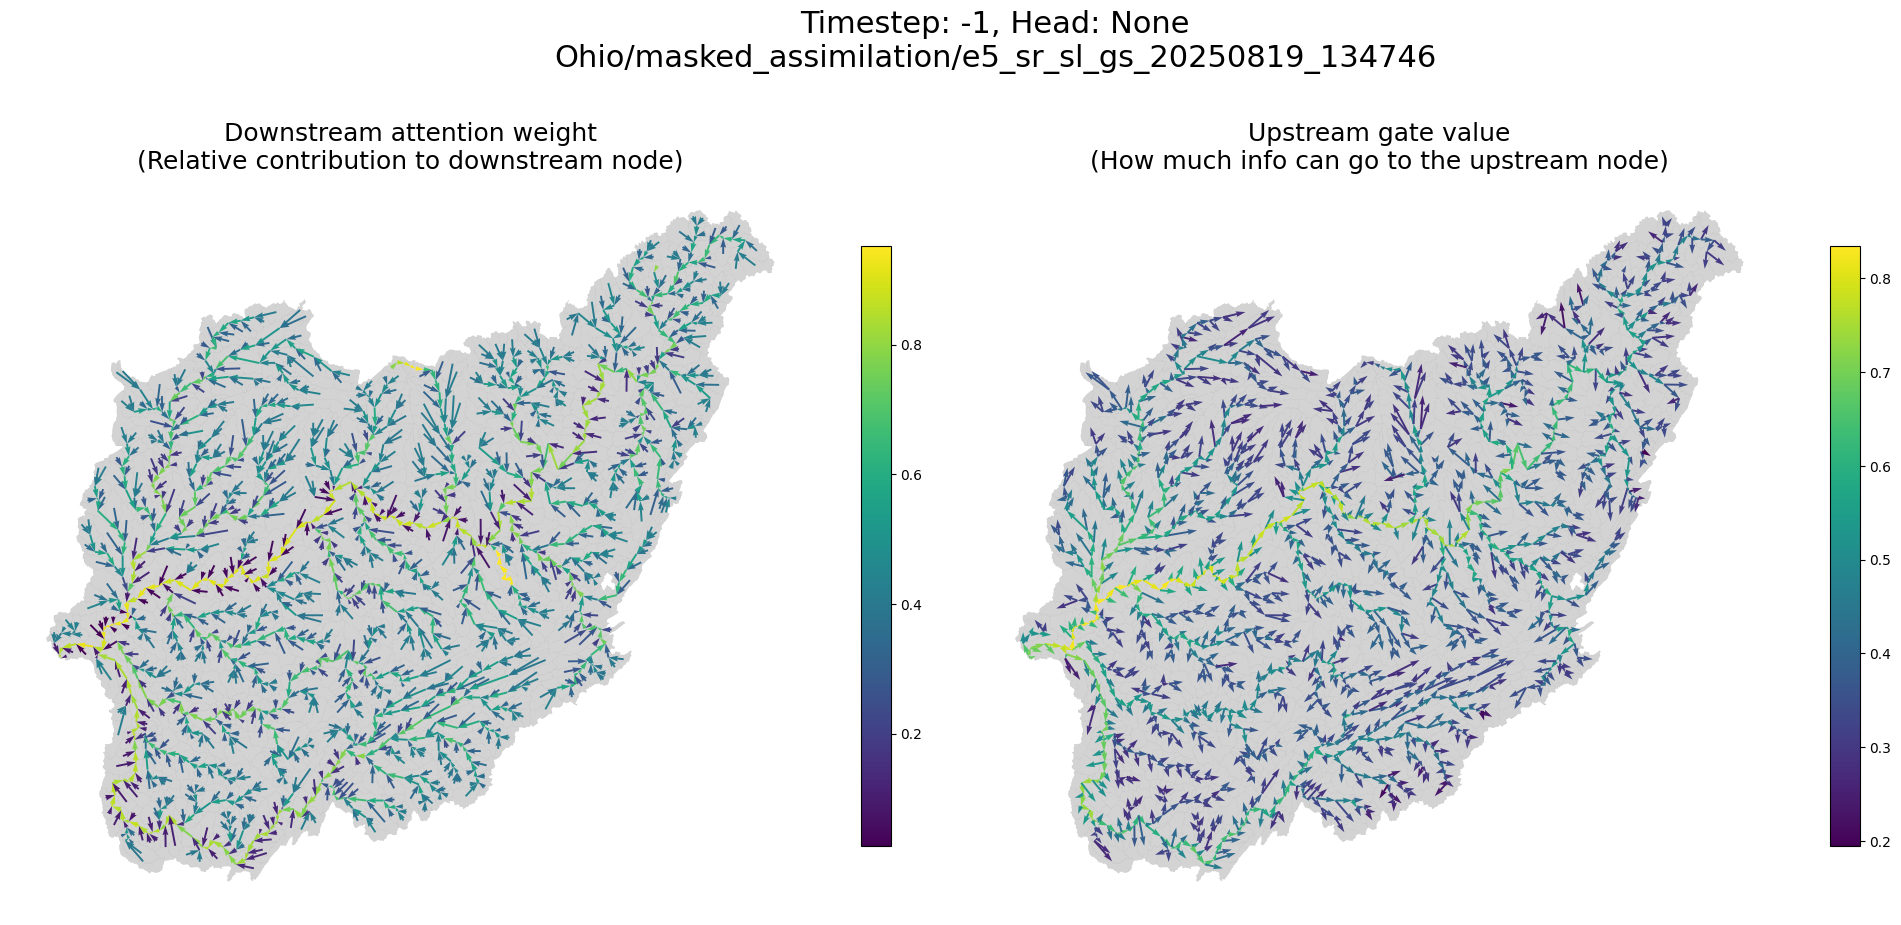

In [11]:
kwargs = {
    'gdf': basins,
    'weights': weights,
    'dataset': dataset,
    'batch_idx': 1,
    'time_idx': -1,
    'head_idx': None,
    'threshold': 0,
}

fig, axes = plt.subplots(1,2, figsize=(20, 10))
plot_attention_arrows(ax=axes[0], direction='fwd', **kwargs)
plot_attention_arrows(ax=axes[1], direction='rev', **kwargs)

axes[0].set_title(f"Downstream attention weight\n(Relative contribution to downstream node)", fontsize=18)
axes[1].set_title(f"Upstream gate value\n(How much info can go to the upstream node)", fontsize=18)


run_title = '/'.join(run_dir.parts[-3:])
title = (f"Timestep: {kwargs['time_idx']}, Head: {kwargs['head_idx']}\n{run_title}\n")
fig.suptitle(title, fontsize=22)
fig.tight_layout()

plt.show()

# fig.savefig(attn_fig_dir / f"{kwargs['time_idx']}_{kwargs['head_idx']}.png", dpi=300)

array([False, False, False, ..., False, False, False])

In [12]:
def make_observation_map(ax, gdf, dataset, batch, sensor, batch_idx, time_idx):
    obs = np.any(~np.isnan(batch['dynamic'][sensor][batch_idx, time_idx, :, :]), axis=-1)
    
    node_ids = [str(i) for i in dataset.nx_graph.nodes]
    gdf['obs'] = False
    gdf.loc[node_ids,'obs'] = obs

    gdf.plot(color='lightgrey', edgecolor='darkgrey', linewidth=0.1, ax=ax)

    if any(obs):
        gdf[gdf['obs']].plot(column='obs', linewidth=0.1, ax=ax)
    
    ax.set_axis_off()

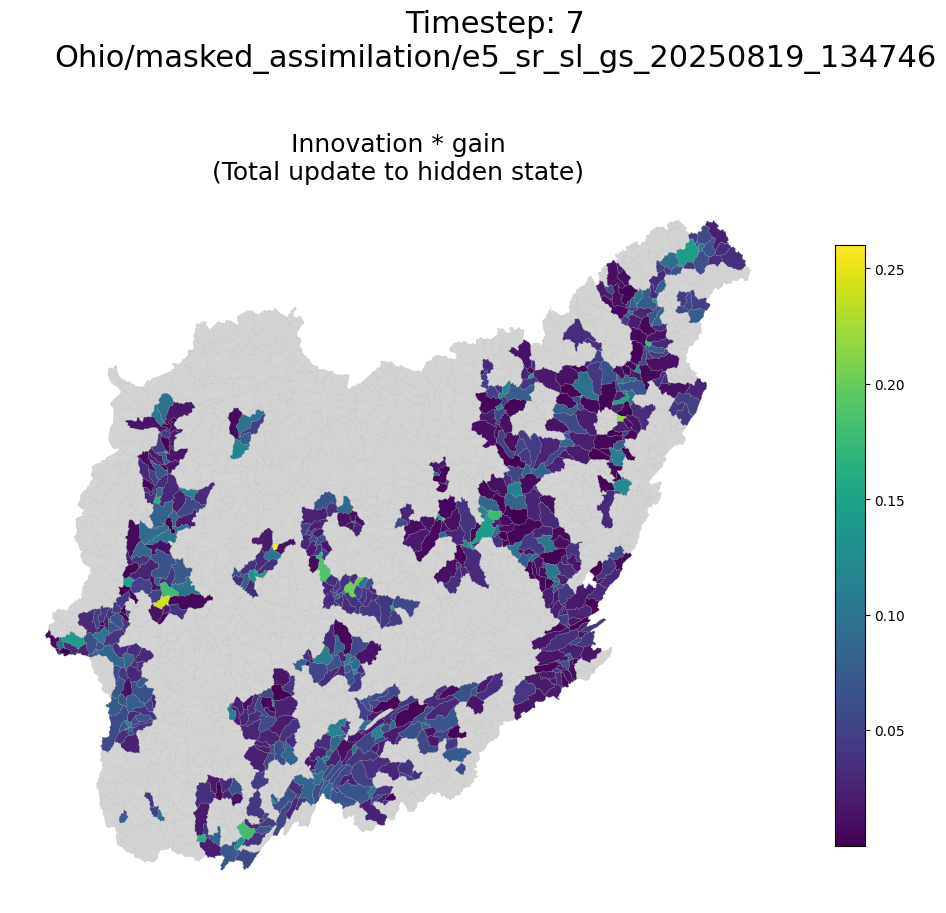

In [14]:
kwargs = {
    'gdf': basins,
    'dataset': dataset,
    'batch_idx': 1,
    'time_idx': 7,
}
sensor = 'glow'

fig, axes = plt.subplots(1,1, figsize=(10, 10))

gain = weights['assim'][sensor]['gain']
nu = weights['assim'][sensor]['nu']

plot_gate_values(ax=axes, gate_weights=gain*nu, **kwargs)
axes.set_title(f"Innovation * gain\n(Total update to hidden state)", fontsize=18)

# make_observation_map(ax=axes[1], batch=batch, sensor=sensor, **kwargs)
# axes[1].set_title("Observations", fontsize=18)

run_title = '/'.join(run_dir.parts[-3:])
title = (f"Timestep: {kwargs['time_idx']}\n{run_title}\n")
fig.suptitle(title, fontsize=22)
fig.tight_layout()

plt.show()

fig.savefig(attn_fig_dir / f"{kwargs['time_idx']}.png", dpi=300)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [16]:
fig_dir

PosixPath('/nas/cee-water/cjgleason/ted/swot-ml/runs/Ohio/masked_assimilation/e5_sr_sl_gs_20250819_134746/figures')

60
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
60


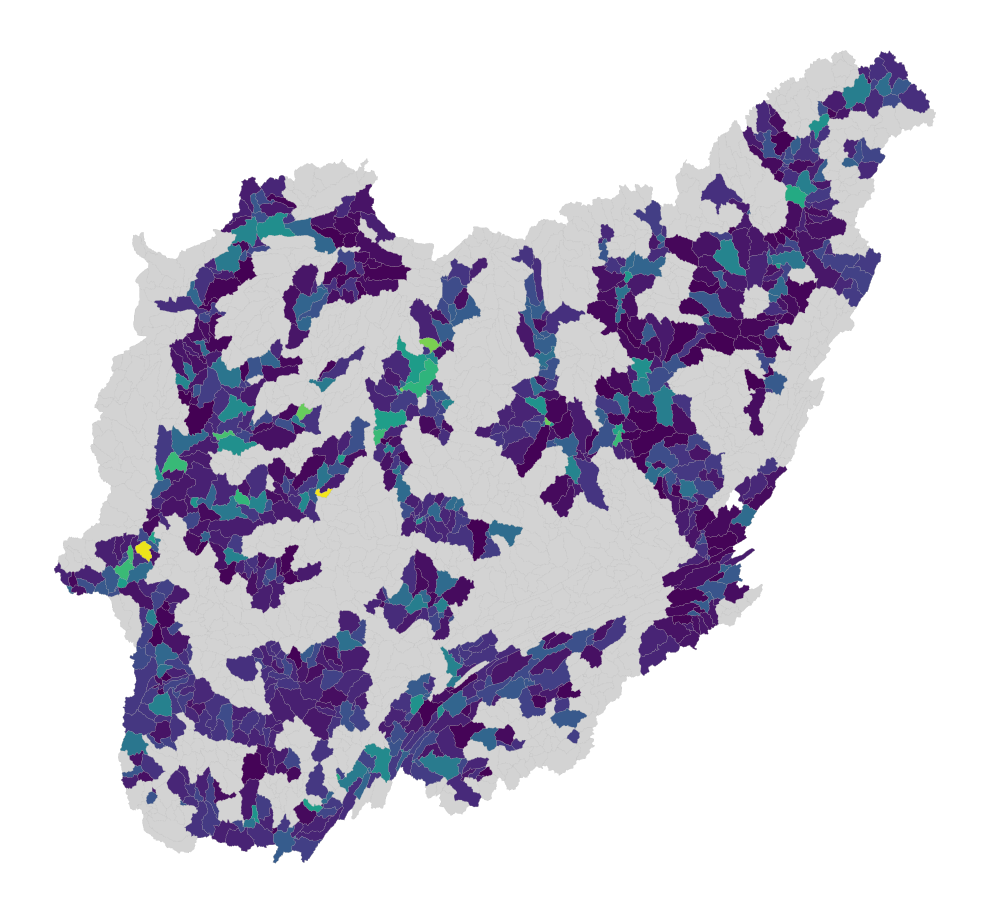

In [20]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib as mpl

kwargs = {
    'gdf': basins,
    'dataset': dataset,
    'batch_idx': 1,
    'time_idx': 9,
}
sensor = 'glow'

gain = weights['assim'][sensor]['gain']
nu = weights['assim'][sensor]['nu']

fig, ax = plt.subplots(1,1, figsize=(10, 10))
axes.set_title(f"Innovation * gain\n(Total update to hidden state)", fontsize=18)
# axes[1].set_title(f"Observations, fontsize=18)")




# Animation update function
def update(frame_timestep):
    print(frame_timestep)
    kwargs['time_idx'] = frame_timestep
    ax.clear()
    plot_gate_values(ax=ax, gate_weights=gain*nu, colorbar=False, **kwargs)
    # make_observation_map(ax=axes[1], batch=batch, sensor=sensor, **kwargs)
    
    # run_title = '/'.join(run_dir.parts[-3:])
    # title = (f"Timestep: {frame_timestep}\n{run_title}\n")
    # fig.suptitle(title, fontsize=22)
    fig.tight_layout()

# timesteps = range(cfg.sequence_length)
timesteps = range(60,90)
# timesteps = [4, 5, 6, 7, 8, 9]
anim = FuncAnimation(fig, update, frames=timesteps, repeat=False)
# Save using ffmpeg
# May change in future. Use `module spider ffmpeg` load one, and then `which ffmpeg` to find it.
ffmpeg_path = "/modules/spack/packages/linux-ubuntu24.04-x86_64_v3/gcc-13.2.0/ffmpeg-7.0.2-hpqh7mjhtopager73y4223ini6rzot3o/bin/ffmpeg"
mpl.rcParams['animation.ffmpeg_path'] = ffmpeg_path
writer = FFMpegWriter(fps=6, bitrate=6000)
anim.save(fig_dir / f"{sensor}_assimilation_steps.mp4", writer=writer)

In [103]:
axes[0].clear()
plt.show()

In [ ]:
weights